## Dependencies

In [129]:
suppressPackageStartupMessages({
    library(data.table)
    library(ggplot2)
    library(dplyr)
    library(IRdisplay)
    library(purrr)
    library(readxl)
    library(tidyr)
    library(tibble)
    #install.packages("ggbeeswarm")
    #install.packages("wesanderson")
    #install.packages("ggridges")
    library(tidyverse)
    library(data.table)
    library(ggbeeswarm)
    library(RColorBrewer)
    library(wesanderson)
    library(ggridges)
})
source("./utils.R")
options(repr.plot.width = 13, repr.plot.height = 8)

## Figure A

### Load and convert metadata

In [130]:
# File path
file_path <- "./data/Meta-benchmark-libd.xlsx"
sheet_names <- excel_sheets(file_path)

# Load each sheet into a list of data frames, adding a "Source" column based on sheet name
data_list <- lapply(sheet_names, function(sheet) {
  df <- read_excel(file_path, sheet = sheet) |> as.data.frame()
  colnames(df)[1] <- "Method"
  rownames(df) <- df[[1]]
  df <- df %>% select(-Method)
  # Convert all columns to numeric 
  df[] <- lapply(df, function(x) as.numeric(as.character(x)))
  # Reshape to long format
  df_long <- df %>%
    rownames_to_column("Method") %>%      
    pivot_longer(-Method,                
                 names_to = "Sample",
                 values_to = "ARI") %>%
    mutate(Source = sheet)              
})

# Combine all sheets into a single data frame
combined_data <- bind_rows(data_list)
combined_data <- combined_data %>%
  group_by(Method) %>%
  filter(!all(is.na(ARI))) %>%
  ungroup()
df <- combined_data %>% filter(!is.na(ARI))

New names:
• `` -> `...1`


### preprocessing

In [106]:
sub <- df %>% filter(Method == 'BayesSpace')
sub$Donor <- ifelse(sub$Sample %in% c("151507", "151508", "151509", "151510"), "Donor1",
                    ifelse(sub$Sample %in% c("151669", "151670", "151671", "151672"), "Donor2", "Donor3"))
sub$ARI <- as.numeric(sub$ARI)
# Calculate median ARI for each Source
source_medians <- sub %>%
  group_by(Source) %>%
  summarize(median_ARI = median(as.numeric(ARI), na.rm = TRUE)) %>%
  arrange(-median_ARI) # Sort by median ARI
ordered_sources <- c("original_paper",
                     source_medians$Source[source_medians$Source != "original_paper"]
)
sub$Source <- factor(sub$Source, levels = ordered_sources)
# Filter out methods that only have 1 ARI values 
sub <- sub %>% filter(!Source %in% c("maple", "SpaceFlow"))
# Consistent method names
sub <- sub %>%
   mutate(across(c(Method, Source), ~ recode(.x, !!!recoding_map)))
# Add lines
line_data <- sub[sub$Sample %in% c("151669", "151673"), ]

### Plot

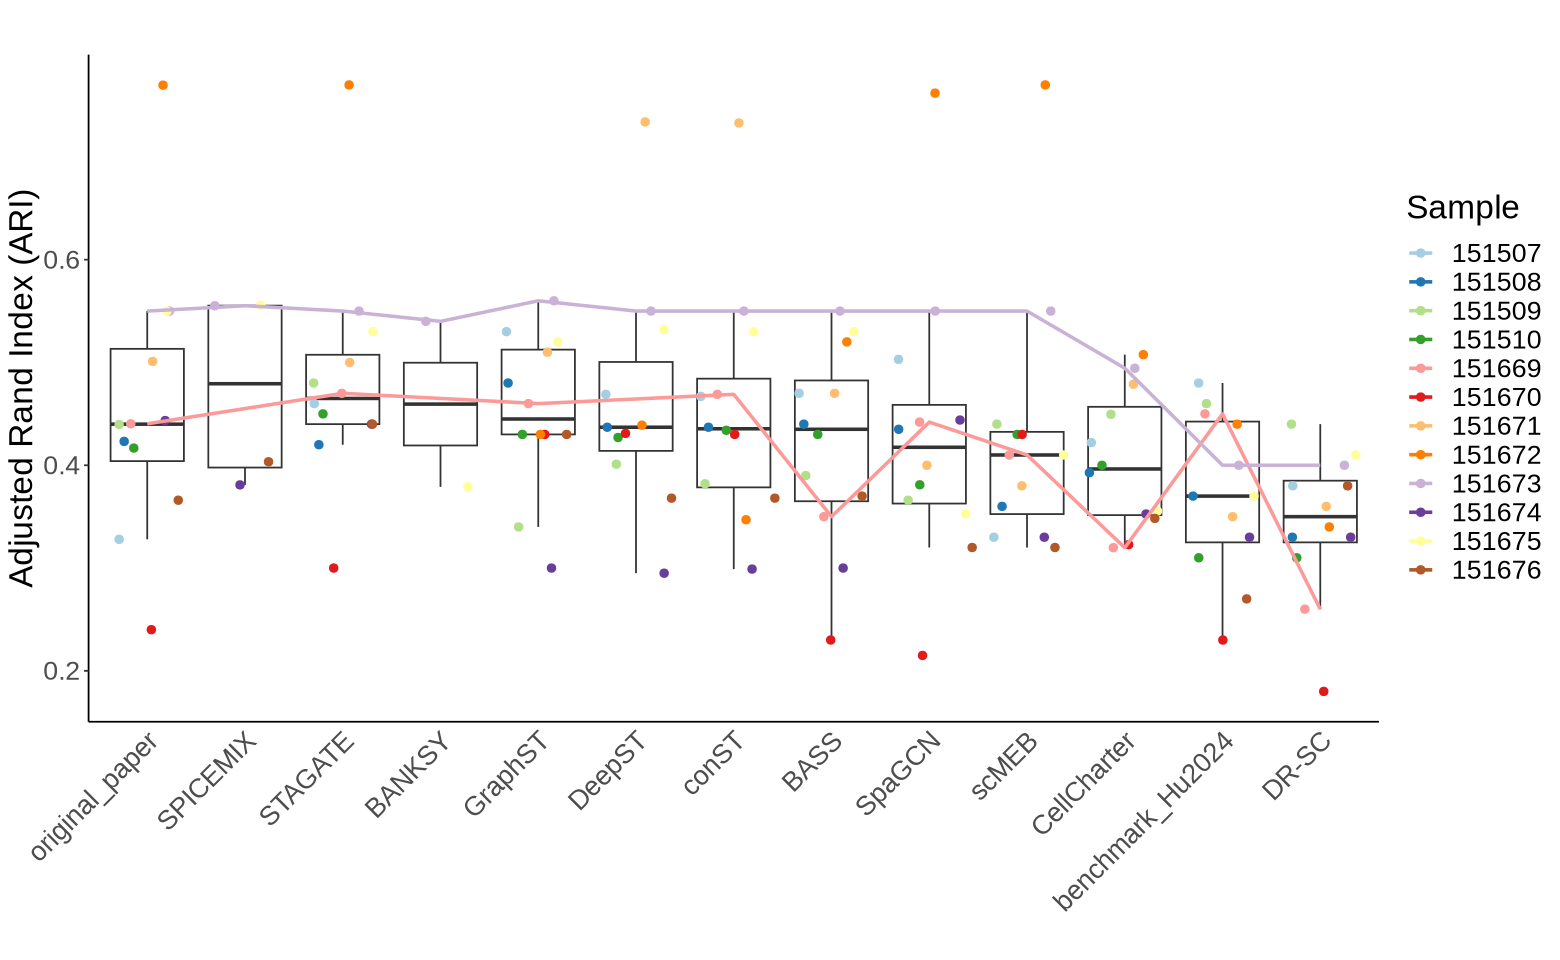

In [107]:
(plot_box <- ggplot(sub, aes(x = Source, y = ARI)) +
    geom_boxplot(aes(group = Source), outlier.shape = NA) + 
    geom_point(aes( color = Sample), size = 2, position = position_jitterdodge(jitter.width = 0.2)) + 
    scale_shape_manual(values = c(16, 17, 15)) + 
    scale_color_brewer(palette = "Paired") +
    theme_classic() +
    geom_line(data = line_data, aes(group = Sample, color = Sample), size = 1) + 
    theme(
      axis.ticks.x = element_blank(),
      axis.text.x = element_text(angle = 45, hjust = 1), 
      text = element_text(size = 20)
    ) +
    labs(title = "", x = "", y = "Adjusted Rand Index (ARI)"))
ggsave("Figure1A.pdf", 
       plot_box, height = 7.5, width = 11, units = "in", dpi=600, device = "pdf") 

## Figure B

### preprocessing

In [131]:
# Ensuring "original_paper" violin is always on the left side
# Excluded methods that had not been applied by at least one subsequent study
df2 <- df %>% filter(!Method %in% c("PRECAST", "SpaceFlow", "Giotto", "SPICEMIX", "SEDR"))
df2$dataset <- ifelse(df2$Source %in% c("original_paper"), "original", "others")
df2 <- df2 %>%
  group_by(Method) %>%
  mutate(dataset = factor(dataset, levels = c("original",  setdiff(unique(dataset), c("original" ))))) %>%
  ungroup()

# Reordering methods by difference between "original_paper" and "SpaceHack"
mean_diff <- df2 %>%
  group_by(Method, dataset) %>%
  summarise(mean_metric_value = mean(ARI, na.rm = TRUE)) %>%
  spread(dataset, mean_metric_value) %>%
  mutate(diff = `others` - `original`) %>%
  ungroup()

# Calculate difference only for methods present in both "original_paper" and "others"
common_methods <- mean_diff %>% filter(!is.na(`original`) & !is.na(`others`))

# Create a factor for reordering based on the difference
df2$Method <- factor(df2$Method, levels = c(common_methods$Method[order(common_methods$diff)], 
                                         setdiff(unique(df2$Method), common_methods$Method)))

df2 <- df2 %>% filter(Method %in% common_methods$Method)
sample_sizes <- df2 %>%
  group_by(Method, dataset) %>%
  summarise(
    sample_size = round(n() / length(unique(Sample)), 0), 
    .groups = 'drop'
  )

max_values <- df2 %>%
  group_by(Method) %>%
  summarise(max_metric_value = max(ARI, na.rm = TRUE), .groups = 'drop')
others_sample_sizes <- sample_sizes %>%
  filter(dataset == "others") %>%
  left_join(max_values, by = "Method")

`summarise()` has grouped output by 'Method'. You can override using the
`.groups` argument.


### plot

In [132]:
figB <- ggplot(df2, aes(Method, ARI, fill = dataset)) +
  geom_split_violin() +
  stat_summary(fun = mean, fun.min = mean, fun.max = mean,
               geom = "crossbar", 
               width = 0.25,
               position = position_dodge(width = .25)) +
  labs(x = NULL, y = "Adjusted Rand Index (ARI)") +
  theme_classic() +
  scale_x_discrete() +
  scale_fill_manual(
      values = c("#333333","#F0F0F0")) +
  theme(text = element_text(size = 25),
        axis.text.x = element_text(angle = 45, hjust = 1), 
        legend.key.size = unit(20, "pt"),
        legend.position = "right", 
        legend.direction = "vertical",
        plot.title = element_text(hjust = 0.5, size = 25),  
        panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank()) +
  guides(fill = guide_legend(ncol = 1, title = "Source")) +
geom_text(data = others_sample_sizes, aes(x = as.numeric(Method) + 0.1, y = max_metric_value, 
                                             label = paste( sample_size)),
            position = position_dodge(width = .25), vjust = -0.5, size = 5, color = "black") +
labs(title = "Self reported ARI vs. ARI from other studies")

ggsave("Figure1B.pdf", figB, height = 8, width = 13, units = "in", dpi=600, device = "pdf") 

## Figure E

### preprocessing

In [133]:
## Load SpaceHack results
resDT <- read.table("./data/SpaceHack_ARI_libd.tsv", sep = "\t", header = TRUE, stringsAsFactors = FALSE)
resDT <- resDT %>%
  group_by(Method) %>%
  mutate(ConfigColor = case_when(
    Config == "config_default" ~ "default",  # If Config is 'config_default', assign 'default'
    TRUE ~ paste0("config", dense_rank(factor(Config)))  # For other configs, assign 'config1', 'config2', etc.
  ))
## Only keep methods that have more than 1 configuration
data <- resDT %>%
  group_by(Method) %>%
  filter(n_distinct(Config) > 1) %>%
  ungroup()
data$metric_value <- data$ARI
data$dataset <- data$ConfigColor
data$method <- data$Method
data <- data %>% 
  as.data.table() %>%
  filter(!is.na(metric_value) & !(metric_value == 'NA'))
data$metric_value <- as.numeric(data$metric_value)
# Calculate the mean of 'metric_value' by 'Sample' and order the result by mean in descending order
dataset_mean <- data[,.(mean = mean(metric_value)), by = dataset][order(-mean),]
data_mean <- data[, .(mean = mean(metric_value)), by = method][order(-mean), ]
method_order <- c(1:nrow(data_mean)) %>% set_names(data_mean$method)
data_region <- data[, .(max = max(metric_value), min = min(metric_value)), by = .(method, dataset)
                    ][, x_pos := method_order[method]][]

In [134]:
### settings for violin plots
bw <- 0.05

wes_dic <- wes_palette[1:length(unique(data$ConfigColor))] %>% set_names(
    c("default", "config1", "config2", "config3", "config4", "config5")
)

densities <-
  data %>%
  group_by(method, dataset) %>%
  summarise(density = list(density(metric_value, bw = bw, from = 0, to = 1, n = 100))) %>%
  mutate(x = map(density, "x"), y = map(density, "y")) %>%
  unnest(x, y) %>%
  ungroup()

densities_stacked <-
  densities %>%
  group_by(method, x) %>%
  mutate(dataset = factor(dataset, dataset_mean$dataset)) %>% # set order of method performance
  arrange(dataset) %>%
  mutate(norm = sum(y), y = y * y, y = y / sum(y) * norm, y = ifelse(is.na(y), 0, y)) %>% # normalise between 0 and 1
  mutate(ymax = cumsum(y), ymin = lag(ymax, default = 0)) %>%
  ungroup() %>%
  group_by(method) %>%
  mutate(ymin = ymin / max(ymax), ymax = ymax / max(ymax)) %>% # normalise so that the maximal density is 1
  ungroup()

densities_violin <-
  densities_stacked %>%
  group_by(method, x) %>%
  mutate(ymax_violin = ymax - max(ymax)/2, ymin_violin = ymin - max(ymax)/2) %>%
  ungroup()

densities_violin$method <- factor(densities_violin$method, levels = data_mean$method)
densities_violin$dataset <- factor(densities_violin$dataset, 
                                    levels = names(wes_dic))
data_mean$method <- factor(data_mean$method, levels = data_mean$method)

`summarise()` has grouped output by 'method'. You can override using the
`.groups` argument.
Warning message:
“`unnest()` has a new interface. See `?unnest` for details.
ℹ Try `df %>% unnest(c(x, y))`, with `mutate()` if needed.”


### plot

In [135]:
figE <-
  ggplot(densities_violin) +
  geom_ribbon(
    aes(
      x,
      ymin = ymin_violin + as.numeric(method),
      ymax = ymax_violin + as.numeric(method),
      fill = dataset,
      group = paste0(method, dataset),
    ), position = "identity"
  ) +
  scale_fill_manual(values=wes_dic)  +
  geom_point(aes(y = method, x = mean), data = data_mean, size = 13, shape = 45, color = "black") +
  scale_x_continuous("Adjusted Rand Index (ARI)", limits = c(0, 1), expand = c(0, 0)) +
  scale_y_discrete("", breaks = factor(data_mean$method), labels = factor(data_mean$method)) +  # Use scale_y_discrete() instead of scale_y_continuous()
  coord_flip() +
  labs(x = "ARI", y = "", title = "ARI for methods with different configurations", fill = "Configuration") +
  theme_pub() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), 
         plot.title = element_text(hjust = 0.5, size = 14, face = "plain"),  # Centere
        legend.position = "right", legend.justification = "left")
ggsave("./Figure1E.pdf", width = 8, height = 5,
       units = "in", dpi = 600, figE)
